In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import os
from scipy.stats import norm


In [2]:
def compute_accuracy(df: pd.DataFrame, col: str, confidence: float = 0.99):
    """
    Compute accuracy, std, standard error, and CI for a column with 'y'/'n' values.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    col : str
        Column name containing 'y' (correct) and 'n' (incorrect).
    confidence : float, optional
        Confidence level for CI (default = 0.99).
    
    Returns
    -------
    dict with:
        - accuracy (float)
        - std (float)
        - se (float)
        - ci_lower (float)
        - ci_upper (float)
        - correct_count (int)
        - total (int)
    """
    correct = (df[col] == 'y').astype(int)
    n = len(correct)
    p = correct.mean()
    std = correct.std(ddof=0)
    se = np.sqrt(p * (1 - p) / n)

    # z-value for chosen confidence level
    z = norm.ppf(1 - (1 - confidence) / 2)

    ci_lower = p - z * se
    ci_upper = p + z * se

    return {
        "accuracy": p,
        "std": std,
        "se": se,
        "ci_lower": max(0, ci_lower),  # clamp to [0,1]
        "ci_upper": min(1, ci_upper),
        "correct_count": correct.sum(),
        "total": n
    }

In [3]:
path = '/mnt/team/TM_Lab/Tony/wr_new/analysis_scripts/gemap/videos2publish'
dfs = [pd.read_csv(os.path.join(path,i,'events.csv')) for i in os.listdir(path)]

In [4]:
df_sum = pd.concat(dfs)

In [5]:
df_sum['Description_Accuracy'] = (df_sum['segment_total']-df_sum['segment_error'])/df_sum['segment_total']

/tmp/ipykernel_448846/3324560534.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Number of Description', 'Description Accuracy'])


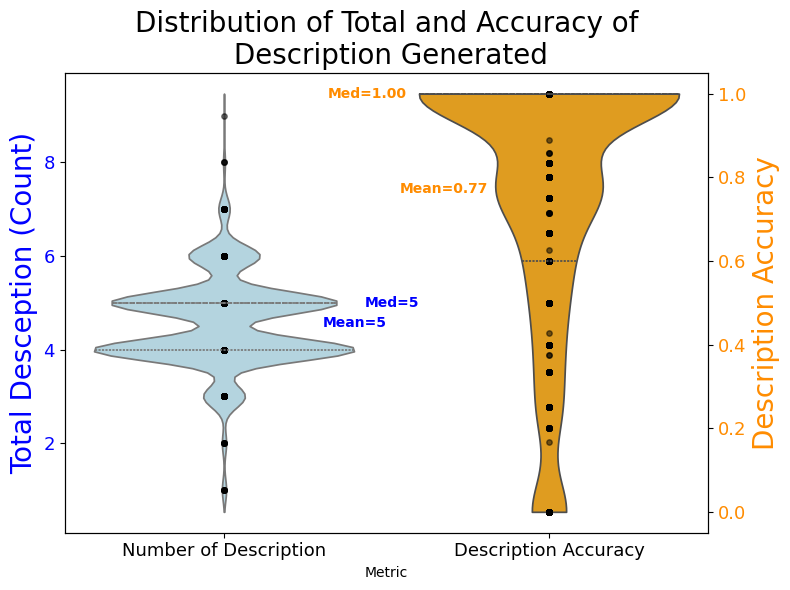

In [7]:
df_sum['Description_Accuracy'] = (
    (df_sum['segment_total'] - df_sum['segment_error']) / df_sum['segment_total']
)

# --- Prepare long dataframe with metric and value ---
df_long = pd.melt(df_sum, value_vars=['segment_total', 'Description_Accuracy'],
                  var_name='Metric', value_name='Value')

fig, ax1 = plt.subplots(figsize=(8,6))

# === Left axis: Segment Total ===
sns.violinplot(
    data=df_long[df_long['Metric']=='segment_total'],
    x='Metric', y='Value',
    ax=ax1, color='lightblue', inner='quartile'
)
ax1.scatter(
    ['segment_total']*len(df_sum),
    df_sum['segment_total'],
    color='black', alpha=0.5, s=15
)
ax1.set_ylabel('Total Desception (Count)', color='blue',size=20)
ax1.tick_params(axis='y', labelcolor='blue')

# Stats left
seg_mean = df_sum['segment_total'].mean()
seg_median = df_sum['segment_total'].median()
ax1.text(0.5, seg_mean, f"Mean={seg_mean:.0f}",
         color='blue', ha='right', va='center', fontweight='bold')

ax1.text(0.6, seg_median, f"Med={seg_median:.0f}",
         color='blue', ha='right', va='center', fontweight='bold')
# === Right axis: Description Accuracy ===
ax2 = ax1.twinx()
sns.violinplot(
    data=df_long[df_long['Metric']=='Description_Accuracy'],
    x='Metric', y='Value',
    ax=ax2, color='orange', inner='quartile', cut=0
)
ax2.scatter(
    ['Description_Accuracy']*len(df_sum),
    df_sum['Description_Accuracy'],
    color='black', alpha=0.5, s=15
)
ax2.set_ylabel('Description Accuracy', color='darkorange',size=20)
ax2.tick_params(axis='y', labelcolor='darkorange')
#ax2.set_ylim(0,1)  # clamp accuracy to [0,1]

# Stats right
acc_mean = df_sum['Description_Accuracy'].mean()
acc_median = df_sum['Description_Accuracy'].median()
ax2.text(0.54, acc_mean, f"Mean={acc_mean:.2f}",
         color='darkorange', ha='left', va='center', fontweight='bold')

ax2.text(0.32, acc_median, f"Med={acc_median:.2f}",
         color='darkorange', ha='left', va='center', fontweight='bold')

# Match x labels
#ax1.set_xticks([0,1])
ax1.tick_params(axis='both', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax1.set_xticklabels(['Number of Descriptions', 'Description Accuracy'])

plt.title('Distribution of Total and Accuracy of\n Description Generated',size=20)
plt.tight_layout()
plt.savefig('Description Accuracy.svg')

In [8]:
results = {}
for c in ['tongue_contact', 'water_drop_stable', 'water_spilled', 'percentage_consumed']:
    results[c] = compute_accuracy(df_sum, c, confidence=0.99)

df_results = pd.DataFrame(results).T

/tmp/ipykernel_448846/742474302.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


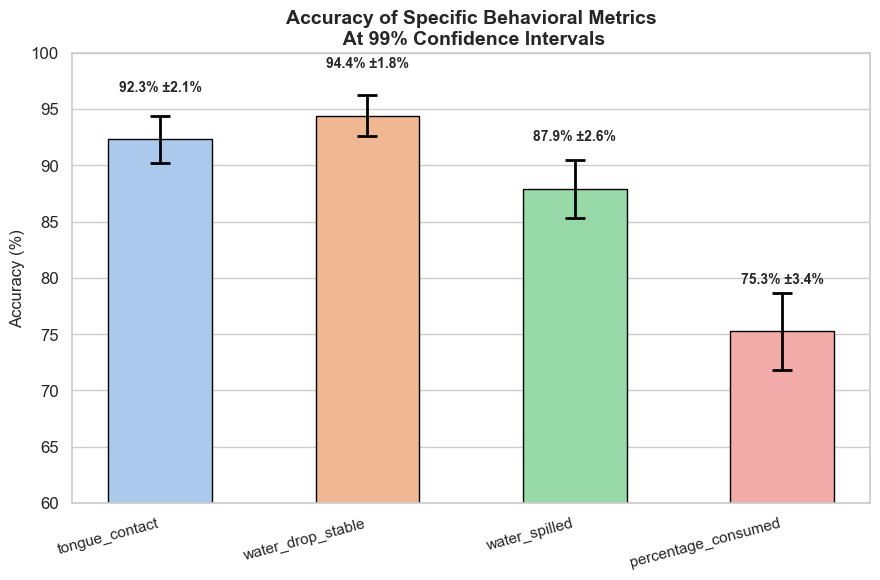

In [19]:
df_results = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'metric'})

# Convert to percentage for better interpretability
df_results['accuracy_pct'] = df_results['accuracy'] * 100
df_results['ci_lower_pct'] = df_results['ci_lower'] * 100
df_results['ci_upper_pct'] = df_results['ci_upper'] * 100

# Calculate symmetric error sizes for error bars
df_results['ci_err_lower'] = df_results['accuracy_pct'] - df_results['ci_lower_pct']
df_results['ci_err_upper'] = df_results['ci_upper_pct'] - df_results['accuracy_pct']

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(9,6))

# Use a color palette to differentiate metrics
palette = sns.color_palette("pastel", len(df_results))

bar = sns.barplot(
    data=df_results,
    x='metric',
    y='accuracy_pct',
    palette=palette,
    edgecolor='black',
    width=0.5   # narrower bars
)

# Add 95% CI error bars manually — thicker & larger caps
plt.errorbar(
    x=range(len(df_results)),
    y=df_results['accuracy_pct'],
    yerr=[df_results['ci_err_lower'], df_results['ci_err_upper']],
    fmt='none', ecolor='black', elinewidth=2, capsize=7, capthick=2
)

# Add accuracy labels above bars
for i, row in df_results.iterrows():
    # average the lower and upper errors to display as ±
    avg_err = (row['ci_err_lower'] + row['ci_err_upper']) / 2
    plt.text(
        i,
        row['accuracy_pct'] + 4,
        f"{row['accuracy_pct']:.1f}% ±{avg_err:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )


plt.ylabel("Accuracy (%)", fontsize=12)
plt.xlabel("")
plt.title("Accuracy of Specific Behavioral Metrics\n At 99% Confidence Intervals", fontsize=14, fontweight='bold')
plt.ylim(60, min(100, df_results['ci_upper_pct'].max()*1.15))
plt.xticks(rotation=15, ha='right', fontsize=11)
plt.tight_layout()
plt.savefig('other_metrics.svg')

/tmp/ipykernel_448846/2538111546.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


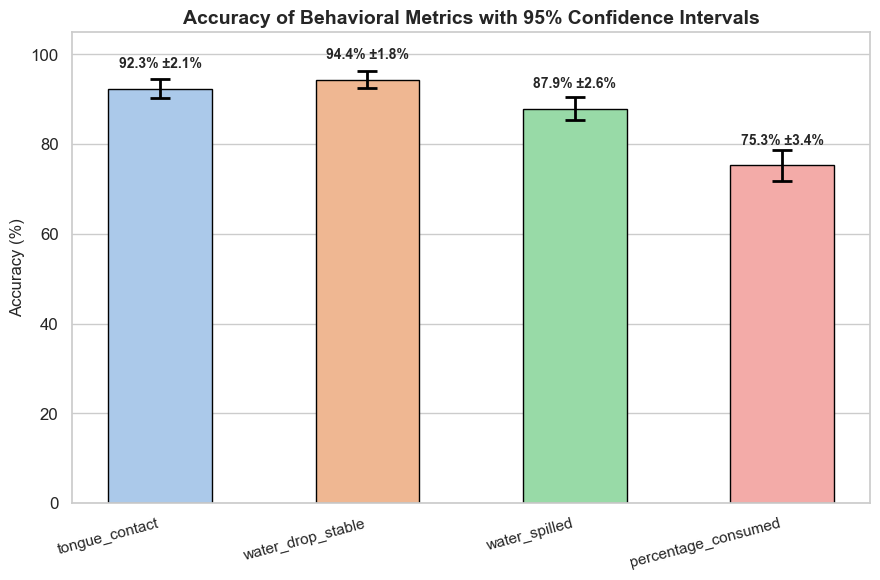

In [12]:
# --- prepare df_results ---
df_results = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'metric'})

# Convert to percentage for better interpretability
df_results['accuracy_pct'] = df_results['accuracy'] * 100
df_results['ci_lower_pct'] = df_results['ci_lower'] * 100
df_results['ci_upper_pct'] = df_results['ci_upper'] * 100

# Calculate symmetric error sizes for error bars
df_results['ci_err_lower'] = df_results['accuracy_pct'] - df_results['ci_lower_pct']
df_results['ci_err_upper'] = df_results['ci_upper_pct'] - df_results['accuracy_pct']

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(9,6))

# Use a color palette to differentiate metrics
palette = sns.color_palette("pastel", len(df_results))

bar = sns.barplot(
    data=df_results,
    x='metric',
    y='accuracy_pct',
    palette=palette,
    edgecolor='black',
    width=0.5
)

# Add 95% CI error bars manually — thicker & larger caps
plt.errorbar(
    x=range(len(df_results)),
    y=df_results['accuracy_pct'],
    yerr=[df_results['ci_err_lower'], df_results['ci_err_upper']],
    fmt='none', ecolor='black', elinewidth=2, capsize=7, capthick=2
)

# Add mean ± CI labels above bars
for i, row in df_results.iterrows():
    # average the lower and upper errors to display as ±
    avg_err = (row['ci_err_lower'] + row['ci_err_upper']) / 2
    plt.text(
        i,
        row['accuracy_pct'] + 4,
        f"{row['accuracy_pct']:.1f}% ±{avg_err:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.ylabel("Accuracy (%)", fontsize=12)
plt.xlabel("")
plt.title("Accuracy of Behavioral Metrics with 95% Confidence Intervals", fontsize=14, fontweight='bold')
plt.ylim(0, min(105, df_results['ci_upper_pct'].max()*1.15))
plt.xticks(rotation=15, ha='right', fontsize=11)
plt.tight_layout()
plt.savefig('other_metrics.svg')

In [85]:
correct.mean()

0.879162702188392